# Attractivity vs Stability

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pydrake.all import (
    DiagramBuilder,
    LogVectorOutput,
    Simulator,
    SymbolicVectorSystem,
    Variable,
)

from underactuated import plot_2d_phase_portrait

## Dynamics of the Nonlinear System
Here we create a Drake dynamical system using the class `SymbolicVectorSystem`.
This requires the dynamics to be written in the form $\dot{\mathbf{x}} = f(\mathbf{x})$, where $\mathbf{x}$ is a vector of Drake symbolic variables.
`SymbolicVectorSystem` is just one of the many options we have in Drake: when systems will get more complicated, writing the dynamics by hand can be rather tedious...

In [2]:
# function that given the current state returns the state time derivative


def dynamics(x):
    r = np.sqrt(x[0] ** 2 + x[1] ** 2)
    return [
        x[0] * (1 - r) - x[1] * (r - x[0]) / (2 * r),
        x[1] * (1 - r) + x[0] * (r - x[0]) / (2 * r),
    ]


# state variables
x1 = Variable("x1")
x2 = Variable("x2")
x = [x1, x2]

# Drake nonlinear system
system = SymbolicVectorSystem(state=x, output=x, dynamics=dynamics(x))

## Drake Diagram
We then construct a Drake diagram.
This is nothing more than a set of interconnected dynamical systems (similiar to the Simulink idea, if you ever used it).
Our diagram will be very simple: we just connect our dynamical system to a logger, which will measure and store the system state during the simulation (similar to the Simulink `To Workspace` block).

In [3]:
# initialize builder of the diagram
builder = DiagramBuilder()

# create the system (we create it again here just to ensure that the code in
# this block is self-contained)
system = SymbolicVectorSystem(state=x, output=x, dynamics=dynamics(x))

# add the system to our diagram
# (note: builder.AddSystem() returns a pointer to the system passed as input,
# hence it is safe to assign the name "system" to its output)
system = builder.AddSystem(system)

# logger block to measure and store the state
# connected to the (first and only) output port of the dynamical system
logger = LogVectorOutput(system.get_output_port(0), builder)

# finalize diagram
diagram = builder.Build()

## Simulation
We are ready to simulate our dynamical system.
To this end we just feed our diagram in a the Drake `Simulator` and `AdvanceTo` the desired time.

In [4]:
# function that given the initial state
# and a simulation time returns the system trajectory


def simulate(x, sim_time):
    # set up the simulator
    simulator = Simulator(diagram)

    # set initial conditions
    # (for now, think of "context" as a synonym of state)
    context = simulator.get_mutable_context()
    context.SetContinuousState(x)

    # simulate from t=0 to t=sim_time
    simulator.AdvanceTo(sim_time)

    # return the output (here = state) trajectory
    return logger.FindLog(context).data()

## Plotting Helper
Let us write a simple function that plots the system trajectory given the initial conditions and the duration of the simulation.

In [5]:
# function that given the initial state
# and a simulation time plots the system trajectory


def plot_trajectory(x, sim_time):
    # simulate the system from the given state
    traj = simulate(x, sim_time)

    # plot a blue dot for the initial conditions
    label = r"$\mathbf{x}(0)=[%.2f,%.2f]^T$" % (x[0], x[1])
    plt.scatter(*x, s=50, c="b", zorder=3, label=label)

    # plot a red curve for the trajectory
    label = r"$\mathbf{x}(t)$"
    plt.plot(traj[0, :], traj[1, :], label=label, c="r")

## Play with the Initial Conditions
Now we can finally visualize the dynamics of our system.
To do this, in the next cell modify the two variables (currently set to arbitrary values):
- `initial_conditions`: state of the system a time zero,
- `sim_time`: duration of the simulation in seconds.

Then, run the last cell to see the result of the simulation.

In [12]:
initial_conditions = [1,1]  # modify here
sim_time = 100  # modify here

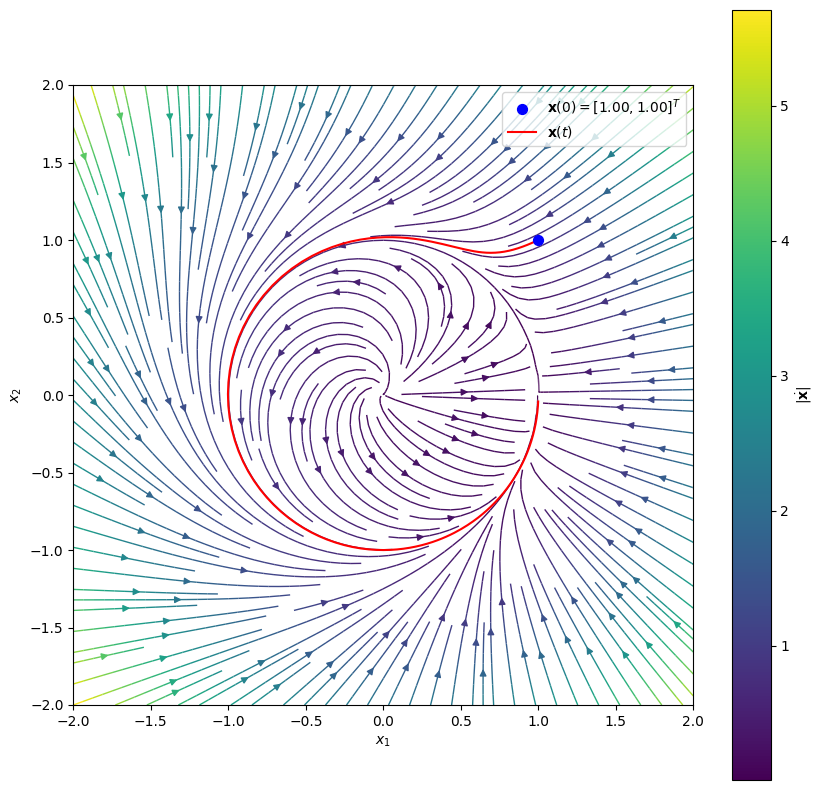

In [15]:
# initialize plot and make it big enough
plt.figure(figsize=(10, 10))

# plot the phase portrait of the 2d system
plot_2d_phase_portrait(dynamics, x1lim=[-2, 2], x2lim=[-2, 2], linewidth=1, density=2)

# superimpose the trajectory to the phase portrait
plot_trajectory(initial_conditions, sim_time)

# add legend
plt.legend(loc=1)